### LightGBM + ADSTuner
* two models, one for causal and the other one for registerd
* added feature engineering
* added year, removed temp
* removing day I got the best results. (The range of days in the train set don't match with test set)


In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

import seaborn as sns

# to use ADSTuner
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

from sklearn.metrics import make_scorer

# see utils.py
from utils import add_features, rmsle, train_encoders, apply_encoders 
from utils import show_tuner_results, show_categoricals

# set seaborn look&feel
sns.set()

import logging

In [2]:
# globals and load train dataset

# number of folds for K-fold cv in ADSTuner
FOLDS = 5

# in secs
TIME_BUDGET = 7200

FILE_TRAIN = "train.csv"
FILE_TEST = "test.csv"

# train dataset
data_orig = pd.read_csv(FILE_TRAIN)

In [3]:
#
# add features
#
data_extended = add_features(data_orig)

# have a look
data_extended.tail()

datetime  season  holiday  workingday  weather   temp  \
10881 2012-12-19 19:00:00       4        0           1        1  15.58   
10882 2012-12-19 20:00:00       4        0           1        1  14.76   
10883 2012-12-19 21:00:00       4        0           1        1  13.94   
10884 2012-12-19 22:00:00       4        0           1        1  13.94   
10885 2012-12-19 23:00:00       4        0           1        1  13.12   

        atemp  humidity  windspeed  casual  registered  count  hour  year  
10881  19.695        50    26.0027       7         329    336    19  2012  
10882  17.425        57    15.0013      10         231    241    20  2012  
10883  15.910        61    15.0013       4         164    168    21  2012  
10884  17.425        61     6.0032      12         117    129    22  2012  
10885  16.665        66     8.9981       4          84     88    23  2012

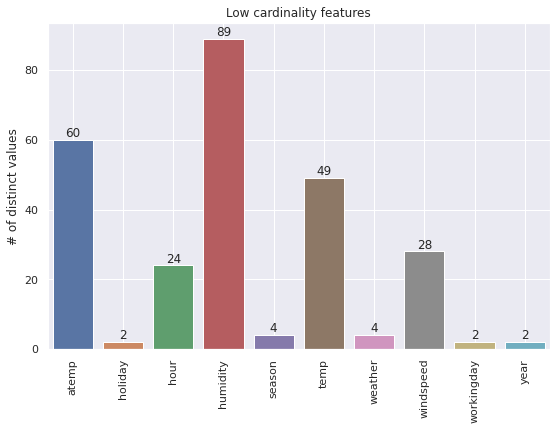

In [4]:
# give a better look at cols with low cardinality
# to decide which one we want to treat as categoricals

# in utils.py
# THR = 100
show_categoricals(data_extended, 100)

In [5]:
# ok, we will treat as categorical: holiday, hour, season, weather, workingday, year

In [6]:
all_columns = data_extended.columns

# cols to be ignored
# atemp and temp are strongly correlated (0.98) we're taking only one
del_columns = ['datetime', 'temp']

# drop ignored columns
data_used = data_extended.drop(del_columns, axis=1)

# let's code categorical
# windspeed need a special treatment
le_list = train_encoders(data_used)

# coding
data_used = apply_encoders(data_used, le_list)

train for coding: season 
train for coding: weather 
train for coding: year 

Coding: season 
Coding: weather 
Coding: year 


In [7]:
cat_cols = ['season', 'holiday','workingday', 'weather', 'hour', 'year']
num_cols = ['atemp', 'humidity', 'windspeed']
target_columns = ['casual', 'registered', 'count']
features = sorted(cat_cols + num_cols)

# define indexes for cat_cols
# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(features) if col in cat_cols]

print('All columns:', len(all_columns))
print('Ignored columns:', len(del_columns))
print('Categorical columns:', len(cat_cols))
print('Numerical columns:', len(num_cols))
print(f'All targets: {len(target_columns)}')
print('All the features', len(features))

All columns: 14
Ignored columns: 2
Categorical columns: 6
Numerical columns: 3
All targets: 3
All the features 9


### ADSTuner session: first model, target = registered

In [8]:
TARGET = 'registered'

#
# Here we define the strategy, the space for hyper-parameters we want to explore
#
params = {'n_estimators': CategoricalDistribution([1000, 2000, 3000, 4000, 5000]),
          'learning_rate': LogUniformDistribution(low=1e-5, high=1e-2),
          'max_depth': IntUniformDistribution(5, 10),
          'use_best_model': True,
          'categorical_feature' : cat_columns_idxs,
         }

alg_reg = lgb.LGBMRegressor()

# define the scorer function for ADSTuner, see def for rmsle before
scorer = make_scorer(rmsle, greater_is_better=False)

# per lista scorer sorted(sklearn.metrics.SCORERS.keys())
tuner = ADSTuner(alg_reg, cv=FOLDS, strategy=params, scoring=scorer, study_name="study1")

x_train = data_used[features]
y_train = data_used[TARGET]

tuner.tune(x_train, y_train, exit_criterion=[TimeBudget(TIME_BUDGET)])

[I 2022-03-02 05:55:00,618] A new study created in RDB with name: study1


In [23]:
# get the status to see if completed
tuner.get_status()

<State.COMPLETED: 5>

In [24]:
show_tuner_results(tuner)

ADSTuner session results:
ADSTuner has completed 504 trials

The best trial is the #: 496
Parameters for the best trial are: {'learning_rate': 0.0037767852662056434, 'max_depth': 8, 'n_estimators': 3000}
The metric used to optimize is: rmsle, greater_is_better=False
The best score is: -0.4831


In [25]:
# look only at completed trials, sorted with best on top. Metric chosen is in the value col.
result_df = tuner.trials[tuner.trials['state'] == 'COMPLETE'].sort_values(by=['value'], ascending=False)

result_df.head(5)

number     value             datetime_start          datetime_complete  \
496     496 -0.483054 2022-03-02 07:53:18.837629 2022-03-02 07:53:32.371091   
153     153 -0.483280 2022-03-02 06:32:21.832451 2022-03-02 06:32:43.927472   
355     355 -0.483791 2022-03-02 07:20:47.613828 2022-03-02 07:21:00.993143   
225     225 -0.483846 2022-03-02 06:51:04.791447 2022-03-02 06:51:17.843289   
386     386 -0.483874 2022-03-02 07:28:06.899961 2022-03-02 07:28:20.243709   

                  duration  params_learning_rate  params_max_depth  \
496 0 days 00:00:13.533462              0.003777                 8   
153 0 days 00:00:22.095021              0.002713                 8   
355 0 days 00:00:13.379315              0.003414                 8   
225 0 days 00:00:13.051842              0.004895                 8   
386 0 days 00:00:13.343748              0.003541                 8   

     params_n_estimators  user_attrs_mean_fit_time  \
496                 3000                  2.344244   
153                 5000                  3.865596   
355                 3000                  2.322171   
225                 3000                  2.251851   
386                 3000                  2.310804   

     user_attrs_mean_score_time  ...               user_attrs_metric  \
496                    0.320362  ...  rmsle, greater_is_better=False   
153                    0.512774  ...  rmsle, greater_is_better=False   
355                    0.314868  ...  rmsle, greater_is_better=False   
225                    0.320307  ...  rmsle, greater_is_better=False   
386                    0.318474  ...  rmsle, greater_is_better=False   

    user_attrs_split0_test_score  user_attrs_split1_test_score  \
496                    -0.802225                     -0.395600   
153                    -0.791370                     -0.406727   
355                    -0.801447                     -0.395551   
225                    -0.793805                     -0.408702   
386                    -0.795509                     -0.392068   

     user_attrs_split2_test_score  user_attrs_split3_test_score  \
496                     -0.454128                     -0.370332   
153                     -0.453192                     -0.365706   
355                     -0.456197                     -0.375200   
225                     -0.452749                     -0.371072   
386                     -0.466667                     -0.370999   

     user_attrs_split4_test_score  user_attrs_std_fit_time  \
496                     -0.392985                 0.057290   
153                     -0.399405                 0.090729   
355                     -0.390559                 0.048368   
225                     -0.392902                 0.051667   
386                     -0.394128                 0.045786   

     user_attrs_std_score_time  user_attrs_std_test_score     state  
496                   0.012179                   0.161972  COMPLETE  
153                   0.013772                   0.156553  COMPLETE  
355                   0.009388                   0.161206  COMPLETE  
225                   0.009738                   0.157275  COMPLETE  
386                   0.014898                   0.159145  COMPLETE  

[5 rows x 21 columns]

In [26]:
%%time
# train the model with chosen parameters
model1 = lgb.LGBMRegressor(**tuner.best_params)

model1.fit(x_train, y_train, categorical_feature=cat_columns_idxs)

CPU times: user 11.8 s, sys: 40.2 ms, total: 11.8 s
Wall time: 2.98 s


LGBMRegressor(learning_rate=0.0037767852662056434, max_depth=8,
              n_estimators=3000)

In [27]:
import pickle

# saving the model best params
tuner.best_params

with open("model1.pkl", "wb") as mode1_file:
    pickle.dump(tuner.best_params, mode1_file)